# RNN Multi Capa con LSTM

$$i_t = \sigma(B_ih_{t-1}+A_ix_t)$$

$$C_t = \tanh(B_ch_{t-1}+A_cx_t)$$

$$f_t = \sigma(B_fh_{t-1}+A_fx_t)$$

$$N_t = i_t\cdot C_t +f_t N_{t-1}$$

$$O_t = \sigma(B_oh_{t-1}+A_ox_t+D_oN_t)$$

$$h_t = O_t\cdot \tanh(N_t)$$

In [2]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data_dir = "../../datasets/shakespeare"
data_file = "shakespeare.txt"
model_path = "shakespeare_model"
full_model_dir = os.path.join(data_dir, model_path)

In [4]:
punctuation = ''.join([x for x in string.punctuation if x not in ['-', "'"]])

In [5]:
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    url = "http://www.gutenberg.org/cache/epub/100/pg100.txt"
    response = requests.get(url)
    s_text = response.content.decode('utf-8')
    s_text = s_text[7675:]
    s_text = s_text.replace("\r\n", '')
    s_text = s_text.replace("\n",'')
    
    with open(os.path.join(data_dir, data_file), "w") as file_out:
        file_out.write(s_text)
else:
    with open(os.path.join(data_dir, data_file), "r") as file_out:
        s_text = file_out.read().replace("\n",'')

In [6]:
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text).strip().lower()

char_list = list(s_text)

In [7]:
session = tf.Session()

num_layers = 3
rnn_size = 128

epoch = 10
batch_size = 100
learning_rate = 0.001
training_seq_len = 50
embedding_size = rnn_size
save_every = 500
eval_every = 50

prime_texts = ['to be or not be', 'thou art more', 'wherefore art thou']

In [8]:
def build_vocabulary(characters):
    chars_count = collections.Counter(characters)
    chars = chars_count.keys()
    char_to_vec = {key:(ix+1) for ix, key in enumerate(chars)}
    char_to_vec['unknown'] = 0
    vec_to_char = {val:key for key, val in char_to_vec.items()}
    return vec_to_char, char_to_vec

In [9]:
vec2word, word2vec = build_vocabulary(s_text)

In [10]:
vocab_size = len(vec2word)+1

In [11]:
vocab_size

41

In [12]:
s_text_vec = []
for x in char_list:
    try: 
        s_text_vec.append(word2vec[x])
    except:
        s_text_vec.append(0)
s_text_vec = np.array(s_text_vec)

In [16]:
class LSTM_Model():
    def __init__(self, embedding_size, rnn_size, num_layers, batch_size, learning_rate, 
                 training_seq_length, vocabulary_size, infer = False ):
        
        self.embedding_size = embedding_size ### guardar en self el objeto embedding_size
        self.num_layers = num_layers
        self.rnn_size = rnn_size
        self.vocabulary_size = vocabulary_size
        self.infer = infer
        self.learning_rate = learning_rate
        
        if infer:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
            
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size) ### cambiado por contrib!!!
        self.lstm_cell = tf.contrib.rnn.MultiRNNCell([self.lstm_cell for _ in range(self.num_layers)])
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])

        
        with tf.variable_scope('lstm_vars'):
            weigths = tf.get_variable('weigths', [self.rnn_size, self.vocabulary_size], tf.float32,
                                tf.random_normal_initializer())
            bias = tf.get_variable('bias', [self.vocabulary_size], tf.float32,
                                tf.constant_initializer(0.0))
            
            embedding_mat = tf.get_variable('embedding_mat', [self.vocabulary_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
            
        def inferred_loop(prev, count):
            prev_trans = tf.add(tf.matmul(prev, weights), bias)
            prev_symbol = tf.stop_gradient(tf.argmax(prev_trans, 1))
            output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed, ### FALTABA UNA S
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer else None)
        
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        
        self.logit_output = tf.add(tf.matmul(output, weigths),bias)
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_func = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_func([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocabulary_size)
        
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state

        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_step = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

        
        
    def sample(self, session, words = vec2word, vocab = word2vec, num = 10, prime_text = 'thou art'):
        state = session.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = list(prime_text)
        for word in word_list[:-1]:
            x = np.zeros((1,1))
            x[0,0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = session.run([self.final_state], feed_dict=feed_dict)
        
        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1,1))
            x[0,0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state: state}
            [model_output, state] = session.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + word
        return out_sentence

In [17]:
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE) as scope:
    lstm_model = LSTM_Model(embedding_size, rnn_size, num_layers, batch_size, learning_rate,
                           training_seq_len, vocab_size)
    scope.reuse_variables()
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, num_layers, batch_size, learning_rate, 
                                training_seq_len, vocab_size, infer=True)
    
    saver = tf.train.Saver()
    num_batches = int(len(s_text_vec)/(batch_size*training_seq_len))+1
    batches = np.array_split(s_text_vec, num_batches)
    batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]### había un for x in batch_size!!! 
    
    session.run(tf.global_variables_initializer())
    
    train_loss = []
    idx_count = 1
    
    for ep in range(epoch):
        random.shuffle(batches)
        targets = [np.roll(x, -1, axis=1) for x in batches]
        print("Epoch actual : "+str(ep+1)+ " / "+str(epoch))
        
        state = session.run(lstm_model.initial_state)
        for ix, batch in enumerate(batches):
            training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
            
            for i, (c, h) in enumerate(lstm_model.initial_state):
                training_dict[c] = state[i].c
                training_dict[h] = state[i].h
            
            temp_loss, state, _ = session.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_step],
                                             feed_dict = training_dict)
            train_loss.append(temp_loss)
            
            if idx_count % 10 == 0:
                summary = (idx_count, ep + 1, ix+1, num_batches+1, temp_loss)
                print("Iteración: {}, Epoch: {}, Batch: {} de {}, Pérdida: {:.2f}".format(*summary))
            if idx_count % save_every == 0:
                model_file_name = os.path.join(full_model_dir, "model")
                saver.save(session, model_file_name, global_step = idx_count)
                print("Modelo guardado correctamente en {}".format(model_file_name))
                
                dict_file = os.path.join(full_model_dir, 'vocab.pkl')
                with open(dict_file, 'wb') as dict_file_conn:
                    pickle.dump([word2vec, vec2word], dict_file_conn)
                    
            if idx_count % eval_every == 0:
                for sample in prime_texts:
                    print(test_lstm_model.sample(session, vec2word, word2vec, num = 100, prime_text = sample))
            
            idx_count += 1

Epoch actual : 1 / 10
Iteración: 10, Epoch: 1, Batch: 10 de 950, Pérdida: 2.99
Iteración: 20, Epoch: 1, Batch: 20 de 950, Pérdida: 2.90
Iteración: 30, Epoch: 1, Batch: 30 de 950, Pérdida: 2.89
Iteración: 40, Epoch: 1, Batch: 40 de 950, Pérdida: 2.88
Iteración: 50, Epoch: 1, Batch: 50 de 950, Pérdida: 2.86
to be or not bee oo  oee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee 
thou art more  ooe e oo e oe e oo e ee oo  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  eee  ooe  
wherefore art thou  eee e ee oe e ee oe e oe e ee oe e oe e ee oe e oe e ee oe e oe e ee oe e oe e ee oe e oe e ee oe 
Iteración: 60, Epoch: 1, Batch: 60 de 950, Pérdida: 2.81
Iteración: 70, Epoch: 1, Batch: 70 de 950, Pérdida: 2.79
Iteración: 80, Epoch: 1, Batch: 80 de 950, Pérdida: 2.78
Iteración: 90, Epoch: 1, Batch: 90 de 950, Pérdida: 2.78
Iteración: 100, Epoch: 1, Batch: 100 de 950, Pérdida: 2.71
to be or not be oo o oo o oo o oo o oo o oo o ou o oo o o

thou art more the so the so the so the so the so the so the so the so the so the so the so the so the so the so t
wherefore art thou so the so the so the so the so the so the so the so the so the so the so the so the so the so the s
Iteración: 660, Epoch: 1, Batch: 660 de 950, Pérdida: 1.95
Iteración: 670, Epoch: 1, Batch: 670 de 950, Pérdida: 1.96
Iteración: 680, Epoch: 1, Batch: 680 de 950, Pérdida: 2.03
Iteración: 690, Epoch: 1, Batch: 690 de 950, Pérdida: 1.99
Iteración: 700, Epoch: 1, Batch: 700 de 950, Pérdida: 1.90
to be or not be the so the say the say the say the say the say the say the say the say the say the say the say the 
thou art more the so the say the say the say the say the say the say the say the say the say the say the say the 
wherefore art thou shall the say the say the say the say the say the say the say the say the say the say the say the s
Iteración: 710, Epoch: 1, Batch: 710 de 950, Pérdida: 1.98
Iteración: 720, Epoch: 1, Batch: 720 de 950, Pérdida: 1.93
Itera

Iteración: 1280, Epoch: 2, Batch: 331 de 950, Pérdida: 1.79
Iteración: 1290, Epoch: 2, Batch: 341 de 950, Pérdida: 1.84
Iteración: 1300, Epoch: 2, Batch: 351 de 950, Pérdida: 1.87
to be or not be the soul the soul the soul the soul the soul the soul the soul the soul the soul the soul the soul 
thou art more the soul the soul the soul the soul the soul the soul the soul the soul the soul the soul the soul 
wherefore art thou shall the soul the soul the soul the soul the soul the soul the soul the soul the soul the soul the
Iteración: 1310, Epoch: 2, Batch: 361 de 950, Pérdida: 1.83
Iteración: 1320, Epoch: 2, Batch: 371 de 950, Pérdida: 1.83
Iteración: 1330, Epoch: 2, Batch: 381 de 950, Pérdida: 1.77
Iteración: 1340, Epoch: 2, Batch: 391 de 950, Pérdida: 1.87
Iteración: 1350, Epoch: 2, Batch: 401 de 950, Pérdida: 1.89
to be or not be the did the did the the did the did the the did the did the the did the did the the did the did the
thou art more the did the did the the did the did the t

wherefore art thou stand the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the
Iteración: 1910, Epoch: 3, Batch: 12 de 950, Pérdida: 1.73
Iteración: 1920, Epoch: 3, Batch: 22 de 950, Pérdida: 1.78
Iteración: 1930, Epoch: 3, Batch: 32 de 950, Pérdida: 1.78
Iteración: 1940, Epoch: 3, Batch: 42 de 950, Pérdida: 1.84
Iteración: 1950, Epoch: 3, Batch: 52 de 950, Pérdida: 1.73
to be or not be the see the see the see the see the see the see the see the see the see the see the see the see the
thou art more the see the see the see the see the see the see the see the see the see the see the see the see the
wherefore art thou shall be the see the see the see the see the see the see the see the see the see the see the see th
Iteración: 1960, Epoch: 3, Batch: 62 de 950, Pérdida: 1.77
Iteración: 1970, Epoch: 3, Batch: 72 de 950, Pérdida: 1.73
Iteración: 1980, Epoch: 3, Batch: 82 de 950, Pérdida: 1.69
Iteración: 1990, Epoch: 3, Batch: 92 de 950, Pérdida: 1.68
I

Iteración: 2540, Epoch: 3, Batch: 642 de 950, Pérdida: 1.79
Iteración: 2550, Epoch: 3, Batch: 652 de 950, Pérdida: 1.65
to be or not be so see the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent th
thou art more the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent 
wherefore art thou shall be shall be the sent the sent the sent the sent the sent the sent the sent the sent the sent 
Iteración: 2560, Epoch: 3, Batch: 662 de 950, Pérdida: 1.68
Iteración: 2570, Epoch: 3, Batch: 672 de 950, Pérdida: 1.61
Iteración: 2580, Epoch: 3, Batch: 682 de 950, Pérdida: 1.76
Iteración: 2590, Epoch: 3, Batch: 692 de 950, Pérdida: 1.67
Iteración: 2600, Epoch: 3, Batch: 702 de 950, Pérdida: 1.60
to be or not be the stranger the strange the strange the strange the strange the strange the strange the strange th
thou art more the strange the strange the strange the strange the strange the strange the strange the strange the
w

wherefore art thou have the company the company the company the company the company the company the company the compan
Iteración: 3160, Epoch: 4, Batch: 313 de 950, Pérdida: 1.71
Iteración: 3170, Epoch: 4, Batch: 323 de 950, Pérdida: 1.65
Iteración: 3180, Epoch: 4, Batch: 333 de 950, Pérdida: 1.63
Iteración: 3190, Epoch: 4, Batch: 343 de 950, Pérdida: 1.68
Iteración: 3200, Epoch: 4, Batch: 353 de 950, Pérdida: 1.65
to be or not be so more the strange the strange the strange the strange the strange the strange the strange the str
thou art more the strange the strange the strange the strange the strange the strange the strange the strange the
wherefore art thou have the strange the strange the strange the strange the strange the strange the strange the strang
Iteración: 3210, Epoch: 4, Batch: 363 de 950, Pérdida: 1.66
Iteración: 3220, Epoch: 4, Batch: 373 de 950, Pérdida: 1.71
Iteración: 3230, Epoch: 4, Batch: 383 de 950, Pérdida: 1.55
Iteración: 3240, Epoch: 4, Batch: 393 de 950, Pérdid

Epoch actual : 5 / 10
Iteración: 3800, Epoch: 5, Batch: 4 de 950, Pérdida: 1.58
to be or not be the man the man the man the man the man the man the man the man the man the man the man the man the
thou art more the world the world the world the world the world the world the world the world the world the world
wherefore art thou the world the world the world the world the world the world the world the world the world the world
Iteración: 3810, Epoch: 5, Batch: 14 de 950, Pérdida: 1.58
Iteración: 3820, Epoch: 5, Batch: 24 de 950, Pérdida: 1.58
Iteración: 3830, Epoch: 5, Batch: 34 de 950, Pérdida: 1.62
Iteración: 3840, Epoch: 5, Batch: 44 de 950, Pérdida: 1.62
Iteración: 3850, Epoch: 5, Batch: 54 de 950, Pérdida: 1.62
to be or not be and the complete the complete the complete the complete the complete the complete the complete the 
thou art more the shall be so so i will not the come the send and the complete the complete the complete the comp
wherefore art thou have the send and the compl

Iteración: 4410, Epoch: 5, Batch: 614 de 950, Pérdida: 1.50
Iteración: 4420, Epoch: 5, Batch: 624 de 950, Pérdida: 1.61
Iteración: 4430, Epoch: 5, Batch: 634 de 950, Pérdida: 1.64
Iteración: 4440, Epoch: 5, Batch: 644 de 950, Pérdida: 1.60
Iteración: 4450, Epoch: 5, Batch: 654 de 950, Pérdida: 1.68
to be or not be so so i will be so so i will be so so i will be so so i will be so so i will be so so i will be so 
thou art more the straight and the straight the straight the straight the straight the straight the straight the 
wherefore art thou shall be so so i will be so so i will be so so i will be so so i will be so so i will be so so i wi
Iteración: 4460, Epoch: 5, Batch: 664 de 950, Pérdida: 1.62
Iteración: 4470, Epoch: 5, Batch: 674 de 950, Pérdida: 1.70
Iteración: 4480, Epoch: 5, Batch: 684 de 950, Pérdida: 1.57
Iteración: 4490, Epoch: 5, Batch: 694 de 950, Pérdida: 1.67
Iteración: 4500, Epoch: 5, Batch: 704 de 950, Pérdida: 1.54
Modelo guardado correctamente en ../../datasets/sha

Iteración: 5050, Epoch: 6, Batch: 305 de 950, Pérdida: 1.70
to be or not be so so more the street and the street and the street and the street and the street and the street an
thou art more the street and the street and the street and the street and the street and the street and the stree
wherefore art thou hast thou hast thou have the street and the street and the street and the street and the street and
Iteración: 5060, Epoch: 6, Batch: 315 de 950, Pérdida: 1.59
Iteración: 5070, Epoch: 6, Batch: 325 de 950, Pérdida: 1.57
Iteración: 5080, Epoch: 6, Batch: 335 de 950, Pérdida: 1.53
Iteración: 5090, Epoch: 6, Batch: 345 de 950, Pérdida: 1.59
Iteración: 5100, Epoch: 6, Batch: 355 de 950, Pérdida: 1.55
to be or not be so so more thersites the strange the strange the strange the strange the strange the strange the st
thou art more the strange the strange the strange the strange the strange the strange the strange the strange the
wherefore art thou shall be so so much and thersites the stra

Iteración: 5660, Epoch: 6, Batch: 915 de 950, Pérdida: 1.61
Iteración: 5670, Epoch: 6, Batch: 925 de 950, Pérdida: 1.59
Iteración: 5680, Epoch: 6, Batch: 935 de 950, Pérdida: 1.57
Iteración: 5690, Epoch: 6, Batch: 945 de 950, Pérdida: 1.61
Epoch actual : 7 / 10
Iteración: 5700, Epoch: 7, Batch: 6 de 950, Pérdida: 1.57
to be or not be the street and the street and the street and the street and the street and the street and the stree
thou art more the strange the strange the strange the strange the strange the strange the strange the strange the
wherefore art thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou shalt thou 
Iteración: 5710, Epoch: 7, Batch: 16 de 950, Pérdida: 1.60
Iteración: 5720, Epoch: 7, Batch: 26 de 950, Pérdida: 1.65
Iteración: 5730, Epoch: 7, Batch: 36 de 950, Pérdida: 1.51
Iteración: 5740, Epoch: 7, Batch: 46 de 950, Pérdida: 1.56
Iteración: 5750, Epoch: 7, Batch: 56 de 950, Pérdida: 1.55
to be or not be the complete with th

thou art more the strange the strange the strange the strange the strange the strange the strange the strange the
wherefore art thou art thou the strange the strange the strange the strange the strange the strange the strange the st
Iteración: 6310, Epoch: 7, Batch: 616 de 950, Pérdida: 1.59
Iteración: 6320, Epoch: 7, Batch: 626 de 950, Pérdida: 1.54
Iteración: 6330, Epoch: 7, Batch: 636 de 950, Pérdida: 1.52
Iteración: 6340, Epoch: 7, Batch: 646 de 950, Pérdida: 1.54
Iteración: 6350, Epoch: 7, Batch: 656 de 950, Pérdida: 1.55
to be or not be so shall be servant the servant the servant the servant the servant the servant the servant the ser
thou art more the servant the servant the servant the servant the servant the servant the servant the servant the
wherefore art thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou
Iteración: 6360, Epoch: 7, Batch: 666 de 950, Pérdida: 1.52
Iteración: 6370, Epoch: 7, Batch: 676 de 950, Pérdida: 1.5

Iteración: 6930, Epoch: 8, Batch: 287 de 950, Pérdida: 1.52
Iteración: 6940, Epoch: 8, Batch: 297 de 950, Pérdida: 1.54
Iteración: 6950, Epoch: 8, Batch: 307 de 950, Pérdida: 1.58
to be or not be the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stra
thou art more the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stra
wherefore art thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou
Iteración: 6960, Epoch: 8, Batch: 317 de 950, Pérdida: 1.47
Iteración: 6970, Epoch: 8, Batch: 327 de 950, Pérdida: 1.54
Iteración: 6980, Epoch: 8, Batch: 337 de 950, Pérdida: 1.64
Iteración: 6990, Epoch: 8, Batch: 347 de 950, Pérdida: 1.60
Iteración: 7000, Epoch: 8, Batch: 357 de 950, Pérdida: 1.55
Modelo guardado correctamente en ../../datasets/shakespeare/shakespeare_model/model
to be or not be so so much and the strange the strange the strange the strange the stra

thou art more that i will not so so so much and the street and the street and the street and the street and the s
wherefore art thou shalt see the counter the street and the street and the street and the street and the street and th
Iteración: 7560, Epoch: 8, Batch: 917 de 950, Pérdida: 1.55
Iteración: 7570, Epoch: 8, Batch: 927 de 950, Pérdida: 1.62
Iteración: 7580, Epoch: 8, Batch: 937 de 950, Pérdida: 1.54
Iteración: 7590, Epoch: 8, Batch: 947 de 950, Pérdida: 1.64
Epoch actual : 9 / 10
Iteración: 7600, Epoch: 9, Batch: 8 de 950, Pérdida: 1.56
to be or not be so the world and the world and the world and the world and the world and the world and the world an
thou art more than the complete works of the complete works of the complete works of the complete works of the co
wherefore art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou 
Iteración: 7610, Epoch: 9, Batch: 18 de 950, Pérdida: 1.51
Iteración: 7620, Epoch: 9, Batch: 28 de

Iteración: 8180, Epoch: 9, Batch: 588 de 950, Pérdida: 1.52
Iteración: 8190, Epoch: 9, Batch: 598 de 950, Pérdida: 1.58
Iteración: 8200, Epoch: 9, Batch: 608 de 950, Pérdida: 1.63
to be or not be so so much and the state and the state and the state and the state and the state and the state and 
thou art more than the state and the state and the state and the state and the state and the state and the state 
wherefore art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou art thou 
Iteración: 8210, Epoch: 9, Batch: 618 de 950, Pérdida: 1.51
Iteración: 8220, Epoch: 9, Batch: 628 de 950, Pérdida: 1.49
Iteración: 8230, Epoch: 9, Batch: 638 de 950, Pérdida: 1.59
Iteración: 8240, Epoch: 9, Batch: 648 de 950, Pérdida: 1.56
Iteración: 8250, Epoch: 9, Batch: 658 de 950, Pérdida: 1.49
to be or not be so should be the straight and the straight and the straight and the straight and the straight and t
thou art more that i have so much a man and the straigh

thou art more than the strength and the strength and the strength and the strength and the strength and the stren
wherefore art thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou hast thou
Iteración: 8810, Epoch: 10, Batch: 269 de 950, Pérdida: 1.52
Iteración: 8820, Epoch: 10, Batch: 279 de 950, Pérdida: 1.43
Iteración: 8830, Epoch: 10, Batch: 289 de 950, Pérdida: 1.55
Iteración: 8840, Epoch: 10, Batch: 299 de 950, Pérdida: 1.49
Iteración: 8850, Epoch: 10, Batch: 309 de 950, Pérdida: 1.52
to be or not be so so much and the strength the strength the strength the strength the strength the strength the st
thou art more than the strength the strength the strength the strength the strength the strength the strength the
wherefore art thou have the strength the strength the strength the strength the strength the strength the strength the
Iteración: 8860, Epoch: 10, Batch: 319 de 950, Pérdida: 1.43
Iteración: 8870, Epoch: 10, Batch: 329 de 950, Pérdi

Iteración: 9420, Epoch: 10, Batch: 879 de 950, Pérdida: 1.55
Iteración: 9430, Epoch: 10, Batch: 889 de 950, Pérdida: 1.57
Iteración: 9440, Epoch: 10, Batch: 899 de 950, Pérdida: 1.60
Iteración: 9450, Epoch: 10, Batch: 909 de 950, Pérdida: 1.45
to be or not be the strength the servant the strength the servant the strength the servant the strength the servant
thou art more that i will not see the servant the strength the servant the strength the servant the strength the 
wherefore art thou hast thou art thou art thou hast thou art thou hast thou art thou hast thou art thou hast thou art 
Iteración: 9460, Epoch: 10, Batch: 919 de 950, Pérdida: 1.54
Iteración: 9470, Epoch: 10, Batch: 929 de 950, Pérdida: 1.54
Iteración: 9480, Epoch: 10, Batch: 939 de 950, Pérdida: 1.52
Iteración: 9490, Epoch: 10, Batch: 949 de 950, Pérdida: 1.50


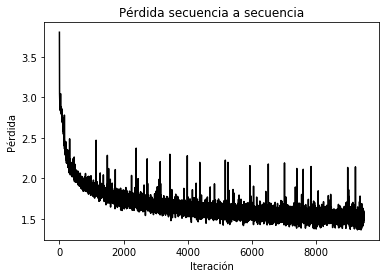

In [18]:
plt.plot(train_loss, 'k-')
plt.title("Pérdida secuencia a secuencia")
plt.xlabel("Iteración")
plt.ylabel("Pérdida")
plt.show()

In [22]:
for sample in ["to be or not to be"]:
    print(test_lstm_model.sample(session, vec2word, word2vec, num = 100, prime_text = sample))

to be or not to be so see the sea the sea the sea the sea the sea the sea the sea the sea the sea the sea the sea the 
